# Setting

In [1]:
import os
import json
import argparse
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

from typing import Callable, List, Dict, NoReturn, Tuple, Union
from tqdm.auto import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AdamW,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    set_seed
)

from datasets import (
    load_metric,
    load_from_disk,
    Sequence,
    Value,
    Features,
    Dataset,
    DatasetDict,
)

from model_encoder import RobertaEncoder, BertEncoder
from retriever.retriever_dense import DenseRetrieval
from retriever.retriever_sparse_TFIDF import SparseRetrievalTFIDF
from retriever.retriever_sparse_BM25 import SparseRetrievalBM25

In [2]:
args = argparse.Namespace(
    dataset_name="../data",
    model_name_or_path="klue/bert-base",
    data_path="/opt/ml/data",
    context_path="wikipedia_documents.json",
    save_dir="./encoders",
    num_neg=0,  
    device="cuda:0",
)

dense_args = TrainingArguments(
    output_dir="dense_retireval",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

set_seed(dense_args.seed)

datasets = load_from_disk('/opt/ml/data/train_dataset') 
val_df = pd.DataFrame(datasets["validation"])

model_checkpoint = args.model_name_or_path  # klue/bert-base
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [3]:
with open(os.path.join(args.dataset_name, args.context_path), "r", encoding="utf-8") as f:
    wiki = json.load(f)
wiki_contexts = list(
    dict.fromkeys([v["text"] for v in wiki.values()])
)  # set 은 매번 순서가 바뀌므로
print(f"Lengths of unique contexts : {len(wiki_contexts)}")

Lengths of unique contexts : 56737


In [4]:
if 'answers' in val_df.columns :
    print('remove answer columns')
    val_df = val_df.drop('answers', 1)
val_df.nunique()

remove answer columns


title                228
context              235
question             240
id                   240
document_id          235
__index_level_0__    238
dtype: int64

# Klue_dense 선언

In [8]:
## Dense retriever
p_encoder = BertEncoder.from_pretrained(model_checkpoint).to(dense_args.device)
q_encoder = BertEncoder.from_pretrained(model_checkpoint).to(dense_args.device)

klue_dense= DenseRetrieval(
    args=dense_args,
    data_path="../data/train_dataset",
    num_neg=args.num_neg,
    tokenizer=tokenizer,
    p_encoder=p_encoder,
    q_encoder=q_encoder,
    save_dir=args.save_dir,
)
klue_dense.load_encoder()
# klue_dense.make_wiki_embedding(batch_size=64)


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertEncoder: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertEncoder: ['cls.predictions.tr

Lengths of unique contexts : 56737
prepare in_batch dataset !!!
loading in_batch encoder !!!
wiki text size : 56737



wiki passage embedding shape:(56737, 768)

Make wiki embedding csv file !!!


In [5]:
wiki_embedding = pd.read_csv('/opt/ml/data/wiki_embedding.csv')

# TFIDF 선언

In [118]:
TFIDF = SparseRetrievalTFIDF(
    tokenize_fn=tokenizer.tokenize,
    data_path=args.dataset_name,
    context_path=args.context_path,
    topR=0
)
TFIDF.get_sparse_embedding()

Lengths of unique contexts : 56737
Embedding pickle load.


# BM25 선언

In [119]:
#### BM25 bulk 계산 빨리하는 방안

In [6]:
BM25 = SparseRetrievalBM25(
    tokenize_fn=tokenizer.tokenize,
    data_path=args.dataset_name,
    context_path=args.context_path,
    topR=0
)
BM25.get_sparse_embedding()

Lengths of unique contexts : 56737
BM25 Embedding pickle load.


In [7]:
def topK_evaluation(
    retriever: Callable,
    query_or_dataset: Union[str, Dataset],
    df: pd.DataFrame,
    Topk_list: Tuple[int] = (5, 10, 15)
    ) -> Tuple[str, dict, int]:
    """[summary]
    Top K개를 리스트로 받아 각 K에 대해서 몇개나 retrieval하는지 counting하는 함수
    Args:
        retriever (Callable):
            retriever class를 넣어줌
        query_or_dataset (Union[str, Dataset]):
            validation dataset
        Topk_list (Tuple[int], optional): 
            확인하고자 하는 topk에 대한 list

    Returns:
        Tuple[str, dict, int]:
            Tuple[0] : Class name
            Tuple[1] : K를 key로 가지는 count dictionary
            Tuple[2] : 검사에 사용하는 Dataframe row 수
    """
    k_countdict = defaultdict(int)
    Total_len = len(query_or_dataset)
    class_name = type(retriever).__name__

    max_K = max(Topk_list) # For loop range

    if 'dense' in class_name.lower() :
        _, doc_indices = retriever.get_relevant_doc_bulk(query_or_dataset['question'], wiki_embedding, k=max_K)
        doc_indices = [indices.tolist() for indices in doc_indices]
    else :
        _, doc_indices = retriever.get_relevant_doc_bulk(query_or_dataset['question'], k=max_K)
    
    for idx, example in enumerate(tqdm(query_or_dataset)):
        ground_truth = example["context"]
        start_binning = 0
        for i, k_binning in enumerate(Topk_list) :                
                docs_binning = [wiki_contexts[doc_idx] for doc_idx in doc_indices[idx][start_binning:k_binning]] # 0~5, 5~10, 10~15 ...
                if ground_truth in docs_binning :
                    for Topk in Topk_list[i:] :
                        k_countdict[Topk] += 1
                    break
                else :
                    start_binning = k_binning
    return class_name, k_countdict, Total_len

In [ ]:
topK_evaluation_list = []
topk_tuple = (5, 10, 15, 50, 100)
for ret in [TFIDF, BM25, klue_dense] :
    print(type(ret).__name__)
    topK_evaluation_list.append(topK_evaluation(ret, datasets["validation"], wiki_embedding, Topk_list=topk_tuple))

In [18]:
ret_eval_file = 'retriever_evalutation_table.csv'
with open(ret_eval_file, 'w') as f :
    f.write('name,'+','.join([str(i) for i in topk_tuple])+',total_count\n')
    for item in topK_evaluation_list :
        name, count_dict, total = item
        
        line = name
        for topk in topk_tuple :
            line += ',' + str(count_dict[topk])
        line += ',' + str(total) +'\n'
        f.write(line)

In [87]:
def score_distribution(
    retriever: Callable,
    query_or_dataset: Union[str, Dataset],
    df: pd.DataFrame
    ) -> Tuple[list, list]:
    Total_len = len(wiki_contexts)
    class_name = type(retriever).__name__

    Total_scores = []
    Correct_scores = []
    
    if 'dense' in class_name.lower() :
        doc_scores, doc_indices = retriever.get_relevant_doc_bulk(query_or_dataset['question'], wiki_embedding, k=Total_len)
        doc_scores, doc_indices = [scores.tolist() for scores in doc_scores], [indices.tolist() for indices in doc_indices]
    else :
        doc_scores, doc_indices = retriever.get_relevant_doc_bulk(query_or_dataset['question'], k=Total_len)
    
    for idx, example in enumerate(tqdm(query_or_dataset)):
        ground_truth = example["context"]
        
        for rank_i, doc_idx in enumerate(doc_indices[idx]) :
            if ground_truth == wiki_contexts[doc_idx] :
                Correct_scores.append((doc_scores[idx][rank_i], rank_i)) ## tuple
                break
        Total_scores.extend(doc_scores[idx][:rank_i]) ## except for Correct score 
        Total_scores.extend(doc_scores[idx][rank_i+1:]) ## except for Correct score
    return Total_scores, Correct_scores

# Plot

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


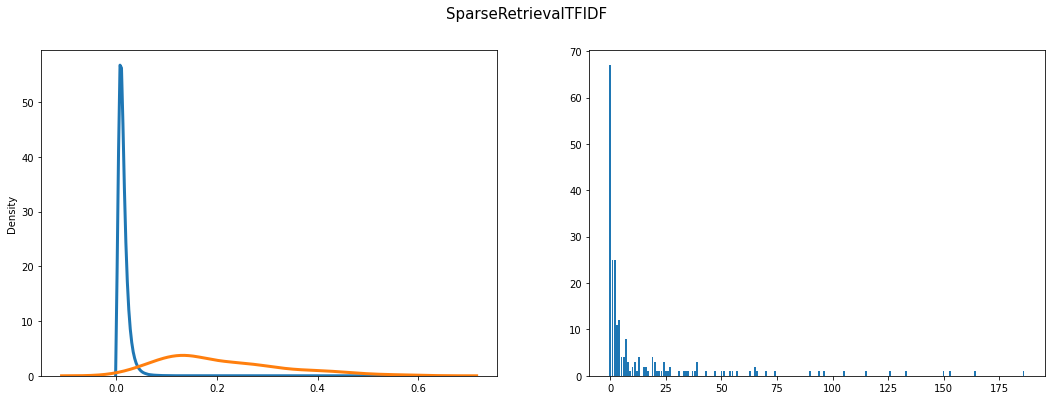

Build BM25 score, indices


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


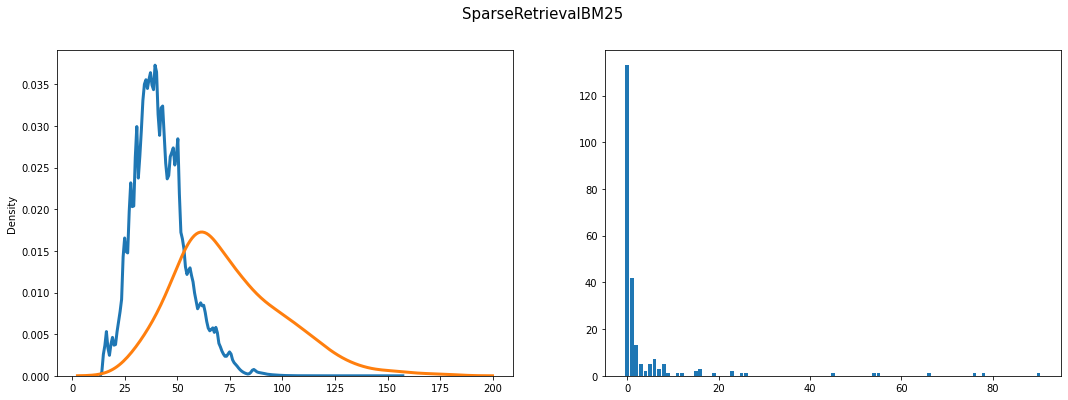

passage size : (56737, 768)


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


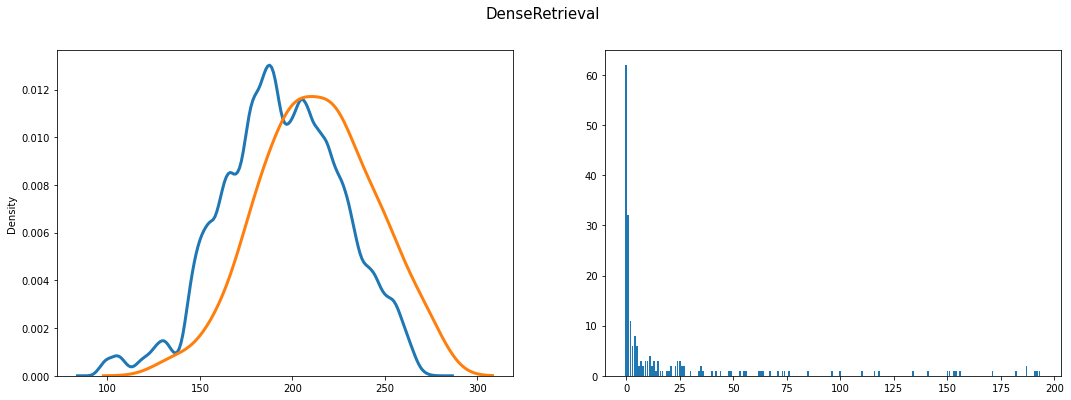

In [102]:
for ret in [TFIDF, BM25, klue_dense] :
    Total_scores, Correct_scores_and_index = score_distribution(ret, datasets["validation"], wiki_embedding)
    correct_scores = [val[0] for val in Correct_scores_and_index]
    correct_index = [val[1] for val in Correct_scores_and_index if val[1] < 200]

    fig, ax = plt.subplots(figsize =(18,6), ncols=2)
    fig.suptitle(type(ret).__name__, fontsize=15)
    
    for idx, l in enumerate([Total_scores, correct_scores]) :
        sns.distplot(l, hist = False, kde = True,
                    kde_kws = {'linewidth': 3},
                    label = idx, ax=ax[0])
    
    key = sorted(Counter(correct_index).keys())
    counts = [Counter(correct_index)[k] for k in key]
    ax[1] = plt.bar(key, counts)

    plt.show()

# Top score ratio count 비교

In [27]:
TFIDF_R85 = SparseRetrievalTFIDF(
    tokenize_fn=tokenizer.tokenize,
    data_path=args.dataset_name,
    context_path=args.context_path,
    topR=0.85
)
TFIDF_R85.get_sparse_embedding()

Lengths of unique contexts : 56737
Embedding pickle load.


In [13]:
BM25_R8 = SparseRetrievalBM25(
    tokenize_fn=tokenizer.tokenize,
    data_path=args.dataset_name,
    context_path=args.context_path,
    topR=0.8
)
BM25_R8.get_sparse_embedding()

Lengths of unique contexts : 56737
BM25 Embedding pickle load.


##  (Top score * ratio) 이상 정답, 오답 passage 분포 확인

In [9]:
def TopR_evaluation(
    retriever: Callable,
    query_or_dataset: Union[str, Dataset],
    df: pd.DataFrame,
    Topk: int =5
    ) -> Tuple[list, list]:
    class_name = type(retriever).__name__
    
    Correct_list = []
    Not_correct_list = []
    
    if 'dense' in class_name.lower() :
        _, doc_indices = retriever.get_relevant_doc_bulk(query_or_dataset['question'], wiki_embedding, k=Topk)
        doc_indices = [indices.tolist() for indices in doc_indices]
         
    else :
        doc_scores, doc_indices = retriever.get_relevant_doc_bulk(query_or_dataset['question'], k=Topk)
    
    for idx, example in enumerate(tqdm(query_or_dataset)):
        ground_truth = example["context"]
        wiki_docs = [wiki_contexts[doc_idx] for doc_idx in doc_indices[idx]]
        if ground_truth in wiki_docs :
            Correct_list.append(len(wiki_docs))
        else:
            Not_correct_list.append(len(wiki_docs))

    return Correct_list, Not_correct_list

# Plot

In [ ]:
topk_tuple = (5, 10, 15, 50, 100)

for ret in [TFIDF_R85, BM25_R85] :
    for topk in topk_tuple :
        Correct_list, Not_correct_list = TopR_evaluation(ret, datasets["validation"], wiki_embedding, Topk=topk)

        fig, axes = plt.subplots(1, 2, figsize =(12,6), sharey=True)
        fig.suptitle(type(ret).__name__+'_Top'+str(topk), fontsize=15) # super
        
        for idx, l in enumerate([Correct_list, Not_correct_list]) :
            key = sorted(Counter(l).keys())
            counts = [Counter(l)[k] for k in key]
            axes[idx].set_title('Correct' if idx == 0 else 'Not Correct')
            axes[idx].bar(key, counts)
        plt.show()


In [105]:
print(Counter(Correct_list))
print(Counter(Not_correct_list))

Counter({1: 49, 2: 27, 3: 21, 100: 13, 4: 13, 5: 9, 9: 6, 6: 6, 7: 5, 12: 5, 10: 4, 25: 3, 18: 3, 15: 3, 17: 3, 21: 3, 11: 3, 8: 2, 14: 2, 65: 2, 37: 2, 19: 2, 13: 2, 29: 2, 49: 2, 28: 2, 34: 2, 54: 2, 26: 2, 51: 1, 82: 1, 39: 1, 35: 1, 46: 1, 92: 1, 72: 1, 32: 1, 47: 1, 41: 1, 78: 1, 16: 1, 40: 1, 67: 1, 23: 1, 33: 1, 45: 1, 36: 1, 42: 1, 22: 1, 98: 1, 20: 1, 44: 1})
Counter({8: 2, 100: 2, 5: 1, 11: 1, 44: 1, 15: 1, 18: 1, 40: 1, 6: 1, 43: 1, 36: 1, 10: 1, 32: 1, 12: 1, 9: 1})
